# Create a kriging metamodel in one dimension

## Abstract

In this example, we create a kriging metamodel for a function which has scalar real inputs and outputs. We show how to create the learning and the validation samples. We show how to create the kriging metamodel by chosing a trend and a covariance model. Finally, we compute the predicted kriging confidence interval using the conditional variance.

## Introduction

We consider the sine function :
$$
y = sin(x)
$$
for any $x\in[0,12]$. 

We want to create a metamodel of this function. This is why we create a sample of $n$ observations of the function :
$$
y_i=sin(x_i)
$$
for $i=1,...,7$, where $x_i$ is the i-th input and $y_i$ is the corresponding output. 

We consider the seven following inputs :

| $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---|
| $x_i$ | 1 | 3 | 4 | 6 | 7.9 | 11 | 11.5 |

We are going to consider a kriging metamodel with a 
* constant trend,
* a Matern covariance model. 

## Creation of the metamodel

We begin by defining the function `g` as a symbolic function. Then we define the `x_train` variable which contains the inputs of the design of experiments of the training step. Then we compute the `y_train` corresponding outputs. The variable `n_train` is the size of the training design of experiments.

In [1]:
import numpy as np
import openturns as ot

In [2]:
g = ot.SymbolicFunction(['x'], ['sin(x)'])

In [3]:
x_train = ot.Sample([1.,3.,4.,6.,7.9,11., 11.5],1)
y_train = g(x_train)
n_train = x_train.getSize()
n_train

7

In order to compare the function and its metamodel, we use a test (i.e. validation) design of experiments made of a regular grid of 100 points from 0 to 12. Then we convert this grid into a `Sample` and we compute the outputs of the function on this sample.  

In [4]:
xmin = 0.
xmax = 12.
n_test = 100
step = (xmax-xmin)/(n_test-1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
x_test_coord = myRegularGrid.getValues()
x_test = ot.Sample(x_test_coord,1)
y_test = g(x_test)

In order to observe the function and the location of the points in the input design of experiments, we define the following functions which plots the data.

In [5]:
def plot_data_train(x_train,y_train):
    '''Plot the data (x_train,y_train) as a Cloud, in red'''
    graph_train = ot.Cloud(x_train,y_train)
    graph_train.setColor("red")
    graph_train.setLegend("Data")
    return graph_train

In [6]:
def plot_data_test(x_test,y_test):
    '''Plot the data (x_test,y_test) as a Curve, in dashed black'''
    graphF = ot.Curve(x_test,y_test)
    graphF.setLegend("Exact")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

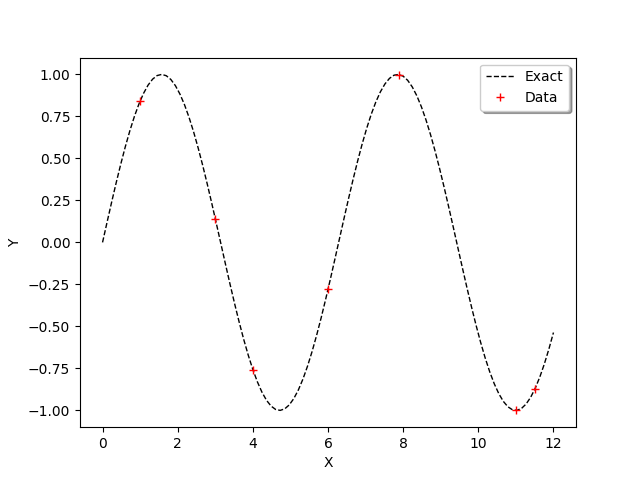

In [7]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

We use the `ConstantBasisFactory` class to define the trend and the `MaternModel` class to define the covariance model. This Matérn model is based on the regularity parameter $\nu=3/2$.

In [8]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.]*dimension, 1.5)
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
print(result)

KrigingResult(covariance models=MaternModel(scale=[0.318568], amplitude=[0.822262], nu=1.5), covariance coefficients=0 : [  1.13905    ]
1 : [  1.01761    ]
2 : [ -1.76279    ]
3 : [ -0.559147   ]
4 : [  1.78757    ]
5 : [ -1.61945    ]
6 : [ -0.00284256 ], basis=[Basis( [class=LinearEvaluation name=Unnamed center=[0] constant=[1] linear=[[ 0 ]]] )], trend coefficients=[[0.00736738]])


We observe that the `scale` and `amplitude` hyper-parameters have been optimized by the `run` method. Then we get the metamodel with `getMetaModel` and evaluate the outputs of the metamodel on the test design of experiments.

In [9]:
krigeageMM = result.getMetaModel()
y_test_MM = krigeageMM(x_test)

The following function plots the kriging data.

In [10]:
def plot_data_kriging(x_test,y_test_MM):
    '''Plots (x_test,y_test_MM) from the metamodel as a Curve, in blue'''
    graphK = ot.Curve(x_test,y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Kriging")
    return graphK

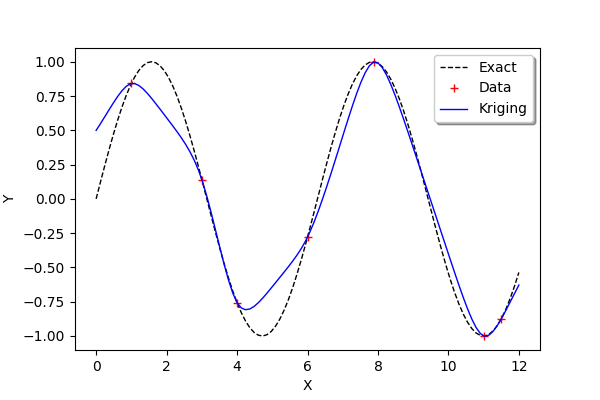

In [11]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.add(plot_data_kriging(x_test,y_test_MM))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

We see that the kriging metamodel is interpolating. This is what is meant by a *conditioning* a gaussian process. 

We see that, when the sine function has a strong curvature between two points which are separated by a large distance (e.g. between $x=4$ and $x=6$), then the kriging metamodel is not close to the function $g$. However, when the training points are close (e.g. between $x=11$ and $x=11.5$) or when the function is nearly linear (e.g. between $x=8$ and $x=11$), then the kriging metamodel is quite accurate.

## Compute confidence bounds

In order to assess the quality of the metamodel, we can estimate the kriging variance and compute a 95% confidence interval associated with the conditioned gaussian process.

We begin by defining the `alpha` variable containing the complementary of the confidence level than we want to compute. Then we compute the quantile of the gaussian distribution corresponding to `1-alpha/2`. Therefore, the confidence interval is :
$$
P\in\left(X\in\left[q_{\alpha/2},q_{1-\alpha/2}\right]\right)=1-\alpha.
$$

In [12]:
N = ot.Normal()
alpha = 0.05
bilateralCI = N.computeBilateralConfidenceInterval(1-alpha)
print("alpha=%f" % (alpha))
quantileAlpha = bilateralCI.getUpperBound()[0]
print("Quantile alpha=%f" % (quantileAlpha))

alpha=0.050000
Quantile alpha=1.959964


In order to compute the kriging error, we can consider the conditional variance. The `getConditionalCovariance` method returns the covariance matrix `covGrid` evaluated at each points in the given sample. Then we can use the diagonal coefficients in order to get the marginal conditional kriging variance. Since this is a variance, we use the square root in order to compute the standard deviation. However, some coefficients in the diagonal are very close to zero and nonpositive, which leads to an exception of the sqrt function. This is why we add an epsilon on the diagonal (nugget factor), which prevents this issue. 

In [13]:
sqrt = ot.SymbolicFunction(["x"],["sqrt(x)"])
epsilon = ot.Point(n_test,1.e-8)
conditionalVariance = result.getConditionalMarginalVariance(x_test)+epsilon
conditionalVarianceSample = ot.Sample(conditionalVariance,1)
conditionalSigma = sqrt(conditionalVarianceSample)

The following figure presents the conditional standard deviation depending on $x$. 

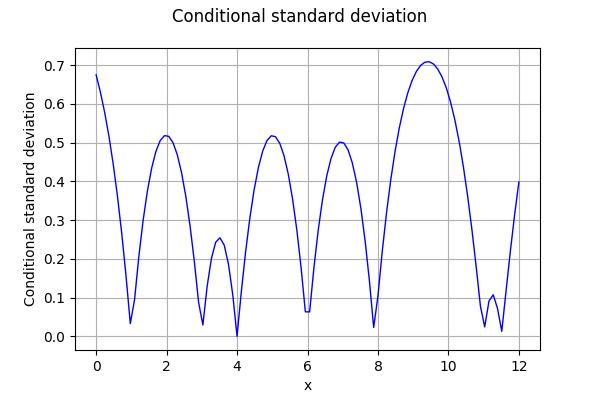

In [14]:
graph = ot.Graph('Conditional standard deviation', 'x', 'Conditional standard deviation', True, '')
curve = ot.Curve(x_test,conditionalSigma)
graph.add(curve)
graph

Then we compute the bounds of the confidence interval.

In [15]:
dataLower = [y_test_MM[i,0] - quantileAlpha * conditionalSigma[i,0] for i in range(n_test)]
dataUpper = [y_test_MM[i,0] + quantileAlpha * conditionalSigma[i,0] for i in range(n_test)]
dataLower = ot.Sample(dataLower,1)
dataUpper = ot.Sample(dataUpper,1)

In order to create the graphics containing the bounds of the confidence interval, we use the `Polygon`. This will create a colored surface associated to the confidence interval. In order to do this, we create the nodes of the polygons at the lower level `vLow` and at the upper level `vUp`. Then we assemble these nodes to create the polygons.

In [16]:
vLow = [[x_test[i,0],dataLower[i,0]] for i in range(n_test)] 
vUp = [[x_test[i,0],dataUpper[i,0]] for i in range(n_test)]

In [17]:
def plot_kriging_bounds(vLow,vUp,n_test):
    '''
    From two lists containing the lower and upper bounds of the region, 
    create a PolygonArray.
    '''
    palette = ot.Drawable.BuildDefaultPalette(2)
    myPaletteColor = palette[1]
    polyData = [[vLow[i], vLow[i+1], vUp[i+1], vUp[i]] for i in range(n_test-1)]
    polygonList = [ot.Polygon(polyData[i], myPaletteColor, myPaletteColor) for i in range(n_test-1)]
    boundsPoly = ot.PolygonArray(polygonList)
    boundsPoly.setLegend("95% bounds")
    return boundsPoly

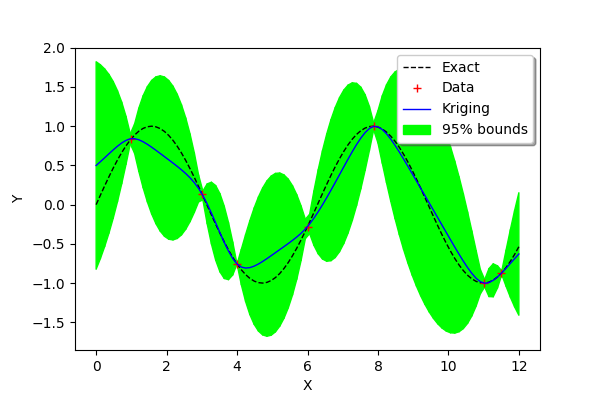

In [18]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.add(plot_data_kriging(x_test,y_test_MM))
graph.add(plot_kriging_bounds(vLow,vUp,n_test))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

We see that the confidence intervals are small in the regions where two consecutive training points are close to each other (e.g. between $x=11$ and $x=11.5$) and large when the two points are not (e.g. between $x=8.$ and $x=11$) or when the curvature of the function is large (between $x=4$ and $x=6$).

## References

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf